In [5]:
import numpy as np
import pandas as pd
import os
# import keyboard
import matplotlib.pyplot as plt

from utils import * #ecef_to_llh, llh_to_ecef
from read_user import User
from read_obs import read_obs_data
from read_base import parse_rinex_observation_data


# dir_path = os.path.dirname(os.path.realpath(__file__))
dir_path = os.getcwd()
# data = 'Munich10Min100m' # 'Circle_radius 100', Eipcycloid, data
data = 'for_real/Case4_Suburban_10Hz' #'Ref' #'Results0219\Munich10min100m' #'Munich_with_propagation' #'Results0219/Munich10min100m' # 'Circle_radius 100', Eipcycloid, data, Urban_Output, for_real/Case1_Suburban, Case1_Urban
folder_path = os.path.join(dir_path, data)

''' Get User Position, IMU, ODM'''
user = User()
user.read_user_data(os.path.join(folder_path, 'UserPos_100.log'))
# user.read_imu_data(os.path.join(folder_path, 'Log_Sensor_True_IMU.log'))
# user.read_odo_data(os.path.join(folder_path, 'Log_Sensor_True_ODO.log')) #Log_Sensor_True_ODM
origin = user.pos_llh[0,:]

'''Get GNSS'''


# NOTE: simulator old version has .24o file, new version has .rnx file 
# rinex_file_path = os.path.join(folder_path + "\Rcv", find_file(folder_path + "\Rcv", 'V', '.rnx')[0]) # 's101325q.24o'
rinex_file_path = os.path.join(folder_path, find_file(folder_path, 'V', '.rnx')[0])
sp3_file_path = [os.path.join(folder_path, find_file(folder_path, 'GPS', '.SP3')[0]), os.path.join(folder_path, find_file(folder_path, 'GAL', '.SP3')[0])]
# sp3_file_path = [os.path.join(folder_path, find_file(folder_path, 'GAL', '.SP3')[0])]
multipath_file_path = os.path.join(folder_path, 'Multipath_U100.log')
rec_pow_file_path = [os.path.join(folder_path, 'ReceivedPower_101_GPS_L1.log'), os.path.join(folder_path, 'ReceivedPower_101_GALILEO_E1.log')]

obs_dir, obs_mp, obs_all, obs_real = read_obs_data(rinex_file_path, sp3_file_path, multipath_file_path = multipath_file_path, rec_pow_file_path = rec_pow_file_path)

'''Static base station'''
base_rinex_file_path = os.path.join(folder_path + "\Ref", find_file(folder_path + "\Ref", 'V', '.rnx')[0]) # 's101325q.24o'
# base_position, base_ecef = [10.004068, -9.993423, 0], False # Ref
# base_position, base_ecef = [4174011.359, 852901.439, 4730709.026], True # 20250730 Urban_Output
base_position, base_ecef = [48.07786620204981, 11.630701090092355, 551.5], False # for_real/Case1_Urban
base_obs = parse_rinex_observation_data(base_rinex_file_path)

In [6]:
# Collect all unique IDs
unique_ids = {obs.id for obs_list in obs_dir.values() for obs in obs_list}
print(sorted(unique_ids))



print('Total obs_dir: ', sum(len(v) for v in obs_dir.values()), 
        ', Total obs_mp: ', sum(len(v) for v in obs_mp.values()), 
        ', Total obs_all: ', sum(len(v) for v in obs_all.values()), 
        ', Total obs_real: ', sum(len(v) for v in obs_real.values()))

# print('Total dir in real obs: ', sum(len(v) for v in obs_real.multipath()))
total_true = sum(v.multipath for v_list in obs_real.values() for v in v_list)
total_false = sum(not v.multipath for v_list in obs_real.values() for v in v_list)
print(f"Real observations with multipath = True: {total_true}") # 1
print(f"Real observations with multipath = False: {total_false}") # 0


# print(len([obs.id for obs_list in obs_real.values() for obs in obs_list if obs.id.startswith('PL01')]))
# print(len([obs.id for obs_list in obs_real.values() for obs in obs_list if obs.id.startswith('G03')]))


for uid in sorted(unique_ids):
    # Get all obs with this id
    obs_list = [obs for obs_list in obs_real.values() for obs in obs_list if obs.id == uid]

    total = len(obs_list)
    mp_true = sum(obs.multipath for obs in obs_list)
    mp_false = total - mp_true

    print(f"{uid}: total={total}, multipath=True={mp_true}, multipath=False={mp_false}, mp percentage={mp_true/(total)}")

['G03', 'G09', 'G14', 'G15', 'G18', 'G19', 'G22', 'G23', 'G27', 'G28', 'PL01', 'PL02', 'PL03', 'PL04', 'PL05', 'PL06']
Total obs_dir:  91878 , Total obs_mp:  211658 , Total obs_all:  303536 , Total obs_real:  91878
Real observations with multipath = True: 45583
Real observations with multipath = False: 46295
G03: total=6001, multipath=True=4660, multipath=False=1341, mp percentage=0.7765372437927012
G09: total=6001, multipath=True=4407, multipath=False=1594, mp percentage=0.7343776037327112
G14: total=6001, multipath=True=4765, multipath=False=1236, mp percentage=0.7940343276120646
G15: total=1863, multipath=True=1463, multipath=False=400, mp percentage=0.7852925389157274
G18: total=6001, multipath=True=4407, multipath=False=1594, mp percentage=0.7343776037327112
G19: total=6001, multipath=True=4836, multipath=False=1165, mp percentage=0.8058656890518247
G22: total=6001, multipath=True=4765, multipath=False=1236, mp percentage=0.7940343276120646
G23: total=6001, multipath=True=4675, mu

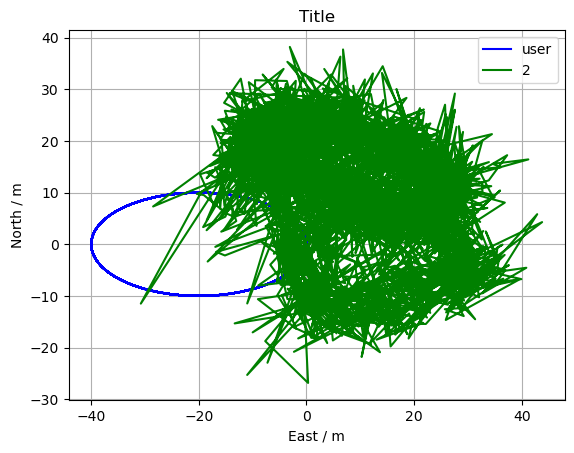

CASES:  2
2D error: Mean: 33.91, Max: 58.26, Min: 6.95


In [7]:
''' Data control (w/wo multipath and PL) ''' 
# used_data = obs_dir # obs_dir, obs_mp, obs_all 
# exclude_PL = False # Set Ture if PL unwanted. True False
# exclude_GPS = False # Set Ture if GPS unwanted.
# exclude_id = [] #, 'G14', 'G18', 'G23', 'G27', 'G02', 'G03', 'G13', 'G19', 'G26', 'G22'

CASES = {
        # 1: [obs_dir, False, False, False],
        2: [obs_all, False, False, False],
        #  3: [obs_real, False, False, False],
        # 4: [obs_real, False, False, True],
        #  4: [obs_dir, False, False, True],
        #  5: [obs_real, False, True, True],
        #  6: [obs_real, True, False, True],
        } # used_data, exclude_PL, exclude_GPS, single_diff_corrected

estimated_ecef, estimated_cb, estimated_llh, estimated_enu = {}, {}, {}, {}
data = {}
overlapped_time, idx1, idx2 = {}, {}, {}
for i, (used_data, exclude_PL, exclude_GPS, single_diff_corrected) in CASES.items():
    estimated_ecef[i], estimated_cb[i], data[i] = [], [], {}
    '''SPP position estimation'''
    for key, values in used_data.items():
        data_obs, sat_positions, pseudoranges = [], [], []
        for obs in values:
            # print('test: ', key, value.id, value.multipath)
            if obs.satellite_pos is None:
                # print("\033[31mError\033[0m: Time: %f, sv_id: %d, No satellite_pos" % (key, obs.sv_id))
                continue
            if (exclude_PL and 'PL' in obs.id) or (exclude_GPS and 'G' in obs.id): # or (obs.id in exclude_id):
                continue
            
            data_obs.append(obs)
            sat_positions.append(obs.satellite_pos)
            bs_ids = [bs_obs.id for bs_obs in base_obs[key]]
            if obs.id not in bs_ids or not single_diff_corrected:
                pseudoranges.append(obs.pseudorange_corrected) # obs.pseudorange
                obs.pseudorange_nav = obs.pseudorange_corrected
            else:
                obs.calculate_pseudorange_single_diff(base_obs[key][bs_ids.index(obs.id)].pseudorange, base_position, ecef_frame=base_ecef)
                pseudoranges.append(obs.pseudorange_single_diff)
                obs.pseudorange_nav = obs.pseudorange_single_diff

        if not data_obs:
            continue

        data[i][key] = data_obs
        receiver_position, clock_bias = single_point_positioning(sat_positions, pseudoranges, np.append(user.pos_ecef[0], 100)) # initial clock bias=100
        estimated_ecef[i].append(receiver_position)
        estimated_cb[i].append(clock_bias)
    np.set_printoptions(precision=10, suppress=False)
    overlapped_time[i], idx1[i], idx2[i] = np.intersect1d(np.asarray(user.user['GPS Time'], dtype=float), np.asarray(list(data[i].keys()), dtype=float), return_indices=True)
    estimated_enu = {
        i: llh_to_enu(ecef_to_llh(est_ecef), origin)
        for i, est_ecef in estimated_ecef.items()
    }

user_enu = llh_to_enu(user.pos_llh, origin)
plot_trajectory({'user': user_enu, **{i: llh_to_enu(ecef_to_llh(est_ecef), origin) for i, est_ecef in estimated_ecef.items()}}, 'Title', 'enu', twoD=True)
plt.show()

# print the 2D error
for i in CASES.keys():
    print('CASES: ', i)
    error = np.linalg.norm(estimated_enu[i][idx2[i], :2]-user_enu[idx1[i], :2], axis=1)
    # print("{}: {:.2f}".format("2D error mean", np.mean(error)))
    print(f"2D error: Mean: {np.mean(error):.2f}, Max: {np.max(error):.2f}, Min: {np.min(error):.2f}")




In [8]:
print(len([obs.id for obs_list in data[4].values() for obs in obs_list if obs.id.startswith('PL01')]))
print(len([obs.id for obs_list in data[4].values() for obs in obs_list if obs.id.startswith('G03')]))

KeyError: 4

In [ ]:
%matplotlib qt
ind_start, ind_end = 520, 1000
skip_by = 1
user_freq_diff = 10 # user frequency difference
plot_trajectory({'user': user_enu[ind_start*user_freq_diff:ind_end*user_freq_diff:skip_by], **{i: llh_to_enu(ecef_to_llh(est_ecef), origin)[ind_start:ind_end:skip_by] for i, est_ecef in estimated_ecef.items()}}, 'plot_title', 'enu', twoD=True, scatter=True)
plt.xlim(-5, 55)  
plt.ylim(-30, 30) 
plt.show()

ImportError: initialization failed

: 

: 

# Save to CSV

In [ ]:
# '''Save results to CSV for learning'''
# file_path = os.path.join(dir_path, 'for_real/Case4_Suburban_10Hz.csv')
# # Get Residual and Pseudorange Corrected - Clock Bias
# Case_for_learning = 4
# Case_ecef = dict(zip(data[Case_for_learning].keys(), estimated_ecef[Case_for_learning])) 
# Case_cb = dict(zip(data[Case_for_learning].keys(), estimated_cb[Case_for_learning]))
# Case_idx1 = dict(zip(data[Case_for_learning].keys(), idx1[Case_for_learning]))

# all_obs_data = []
# for key, obs_list in data[Case_for_learning].items():
#     for obs in obs_list:
#         obs.calculate_azimuth_elevation(user.pos_ecef[Case_idx1[key]])
#         obs.calculate_pseudorange_residual(Case_ecef[key], Case_cb[key], obs.pseudorange_nav)

#         all_obs_data.append({
#             'gps_time': key,
#             'satellite_id': obs.id,
#             'sv_id': obs.sv_id,
#             'pseudorange': obs.pseudorange,
#             'doppler_shift': obs.doppler_shift,
#             'cn0': obs.CN0,
#             'rec_pow': obs.rec_pow,
#             'azimuth': obs.azimuth,
#             'elevation': obs.elevation,
#             'pseudorange_residual': obs.pseudorange_residual,
#             'pseudorange_corrected_cb': obs.pseudorange_nav - Case_cb[key],
#             'multipath': obs.multipath,
#         })

# # Convert the list of dictionaries to a DataFrame and save it as a CSV file
# pd.DataFrame(all_obs_data).to_csv(file_path, index=False)
# print(f"Obseration data has been saved to {file_path}")

Obseration data has been saved to c:\Users\Ce\OneDrive\simulation\for_real/Case4_Suburban_10Hz.csv


: 

: 

: 

: 